In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import os
import shutil
from tqdm import tqdm  #visualize loop
from datetime import date
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

## Import weather station inventory

In [2]:
# Importing weather station list from Canada Government 
# Source: https://collaboration.cmc.ec.gc.ca/cmc/climate/Get_More_Data_Plus_de_donnees/

df = pd.read_csv('data/Station Inventory EN.csv', skiprows=3)

# Removing station without data after 2020
df = df.loc[df['DLY Last Year'] > 2020].reset_index(drop=True)
df.shape

(1439, 19)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Name                         1439 non-null   object 
 1   Province                     1439 non-null   object 
 2   Climate ID                   1439 non-null   object 
 3   Station ID                   1439 non-null   int64  
 4   WMO ID                       905 non-null    float64
 5   TC ID                        1119 non-null   object 
 6   Latitude (Decimal Degrees)   1439 non-null   float64
 7   Longitude (Decimal Degrees)  1439 non-null   float64
 8   Latitude                     1439 non-null   float64
 9   Longitude                    1439 non-null   float64
 10  Elevation (m)                1432 non-null   float64
 11  First Year                   1439 non-null   int64  
 12  Last Year                    1439 non-null   int64  
 13  HLY First Year    

## Creating functions for data extraction

In [4]:
# splitting month in season:
season = {1:[12,1,2], 2:[3,4,5], 3:[6,7,8], 4:[9,10,11]}
season1 = {'Winter':[12,1,2], 'Spring':[3,4,5], 'Summer':[6,7,8], 'Fall':[9,10,11]}

# Function to map the season in the dataframe:
def map_season(month):
    for key, value in season.items():
        if month in value:
            return key
        
def map_season1(month):
    for key, value in season1.items():
        if month in value:
            return key

In [5]:
# Function to download data per year for each weather station

def download_weather_data(province, station_id, start_year, end_year):

    # Create a directory to store the downloaded files
    directory = f"data/Weather station all/{province}_weather_data_{station_id}"
    os.makedirs(directory, exist_ok=True)
    year_list = []
    weather = pd.DataFrame()
    error = []

    # Fetching data from Canada government web site of weather historical data
    for year in range(start_year, end_year + 1):
        base_url = f"https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={station_id}&Year={year}&timeframe=2&submit= Download+Data"
        try:
            response = requests.get(base_url)
            if response.status_code == 200:
                with open(f"{directory}/weather_data_{station_id}_{year}.csv", "wb") as file:
                    file.write(response.content)
                year_list.append(year)
            else:
                error.append(year)
        except:
            error.append(year)
            
    ## Evaluation of null data to keep or remove csv
    # Concatenate all csv for the station into one dataframe
    for year1 in year_list:
        csv_link = f'data/Weather station all/{province}_weather_data_{station_id}/weather_data_{station_id}_{year1}.csv'
        station_data = pd.read_csv(csv_link)
        station_data['StationId'] = station_id
        station_data['Province'] = province
        weather = pd.concat([station_data, weather], axis=0).reset_index(drop=True)
    weather = weather[['Province','StationId', 'Station Name', 'Longitude (x)', 'Latitude (y)', 'Date/Time','Year',
         'Month', 'Day','Max Temp (°C)','Min Temp (°C)', 'Total Precip (mm)']]
    # To remove future date from today
    weather['Date/Time'] = pd.to_datetime(weather['Date/Time'], format='ISO8601')
    date_now = pd.to_datetime(date.today(),format='ISO8601')
    weather = weather.loc[weather['Date/Time'] < date_now]
    # Adding season information
    weather['Season_num'] = weather['Month'].apply(map_season)
    weather['Season'] = weather['Month'].apply(map_season1)
    # Null value evaluation
    group = ['Province','StationId','Station Name','Longitude (x)','Latitude (y)']
    null_data = weather.set_index(group)
    null_data = null_data.groupby(group)[['Max Temp (°C)',
                                            'Min Temp (°C)', 
                                            'Total Precip (mm)']].apply(lambda x: x.isnull().sum())
    null_data = null_data.sum(axis=1)
    res = null_data.to_frame().rename({0:'SUM_NULL'}, axis=1)
    res['ALL'] = len(weather)*3
    res['Pourcent_missing'] = res['SUM_NULL']/res['ALL']*100
    pourcent = res['Pourcent_missing'].values
    
    # Only keeping data with less than 30% null value
    if res['Pourcent_missing'].values[0] > 30:
         status = False
         # For deleting the directory containing the data
         shutil.rmtree(directory)
    else: 
        status = True
    summary = pd.DataFrame({'Province':province,
                            'Station ID':[station_id],
                            'Status':[status],
                            'Null pourcent':pourcent, 
                            'Min_Year':[min(year_list)],
                            'Max_Year':[max(year_list)],
                            'error':[error]})
    return summary

## Extracting data

In [23]:
## Very long to run
# Executing the function to download data for each province

result_all = pd.DataFrame()
for province in df['Province'].unique():
    result = pd.DataFrame()
    data = df.loc[df['Province'] == province].reset_index(drop=True)
    for i in tqdm(range(len(data))):
        start_year = 2020
        end_year = 2024
        data1 = download_weather_data(data['Province'].iloc[i],data['Station ID'].iloc[i],start_year,end_year)
        result = pd.concat([result, data1], ignore_index=True)
    result.to_csv(f'dataset/{province}_resultdf.csv')
result_all.to_csv('dataset/AllProvinces_resultdf.csv')


100%|██████████| 54/54 [08:05<00:00,  8.99s/it]


## Creating the weather dataset

In [8]:
# All weather data in one dataframe for preprocessing and modeling
weather = pd.DataFrame()
error = []

for province in df['Province'].unique():
    weather_pv = pd.DataFrame()
    result_imp = pd.read_csv(f'dataset/{province}_resultdf.csv')
    result_imp = result_imp.loc[result_imp['Province'] == province]
    min_year = result_imp['Min_Year'].min()
    max_year = result_imp['Max_Year'].max()
    stations = result_imp['Station ID'].loc[result_imp['Status'] ==True].unique()
    for station in stations:
        for year in range(min_year,max_year+1):
            try:
                station_data = pd.read_csv(f'data/Weather station all/{province}_weather_data_{station}/weather_data_{station}_{year}.csv')
                station_data['StationId'] = station
                station_data['Province'] = province
                weather= pd.concat([station_data, weather], axis=0).reset_index(drop=True)
                weather_pv = pd.concat([station_data, weather_pv], axis=0).reset_index(drop=True)
            except:
                error.append((province,station,year))
    weather_pv.to_csv(f'dataset/Weather_{province}_data.csv')
    print(province)
weather.to_csv('dataset/Weather_all_data.csv')

BRITISH COLUMBIA
YUKON TERRITORY


In [6]:
weather1 = pd.read_csv('dataset/Weather_all_data.csv')

In [7]:
weather1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826270 entries, 0 to 1826269
Data columns (total 34 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   Longitude (x)              float64
 2   Latitude (y)               float64
 3   Station Name               object 
 4   Climate ID                 object 
 5   Date/Time                  object 
 6   Year                       int64  
 7   Month                      int64  
 8   Day                        int64  
 9   Data Quality               object 
 10  Max Temp (°C)              float64
 11  Max Temp Flag              object 
 12  Min Temp (°C)              float64
 13  Min Temp Flag              object 
 14  Mean Temp (°C)             float64
 15  Mean Temp Flag             object 
 16  Heat Deg Days (°C)         float64
 17  Heat Deg Days Flag         object 
 18  Cool Deg Days (°C)         float64
 19  Cool Deg Days Flag         object 
 20  To

In [8]:
remove = ['Max Temp Flag','Min Temp Flag','Mean Temp Flag','Cool Deg Days Flag','Heat Deg Days Flag',
    'Total Snow Flag','Total Precip Flag','Snow on Grnd Flag','Dir of Max Gust Flag','Spd of Max Gust Flag',
     'Total Rain Flag', 'Data Quality','Unnamed: 0']
valid_weather = weather1.copy().drop(remove, axis=1)
valid_weather['Date'] = pd.to_datetime(valid_weather[['Year', 'Month', 'Day']])
valid_weather = valid_weather.loc[valid_weather['Date'] < '2024-04-30']
valid_weather.columns

Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
       'Date/Time', 'Year', 'Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)',
       'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)',
       'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
       'Snow on Grnd (cm)', 'Dir of Max Gust (10s deg)',
       'Spd of Max Gust (km/h)', 'StationId', 'Province', 'Date'],
      dtype='object')

In [9]:
valid_weather['Date'].max()

Timestamp('2024-04-29 00:00:00')

<Axes: ylabel='Year'>

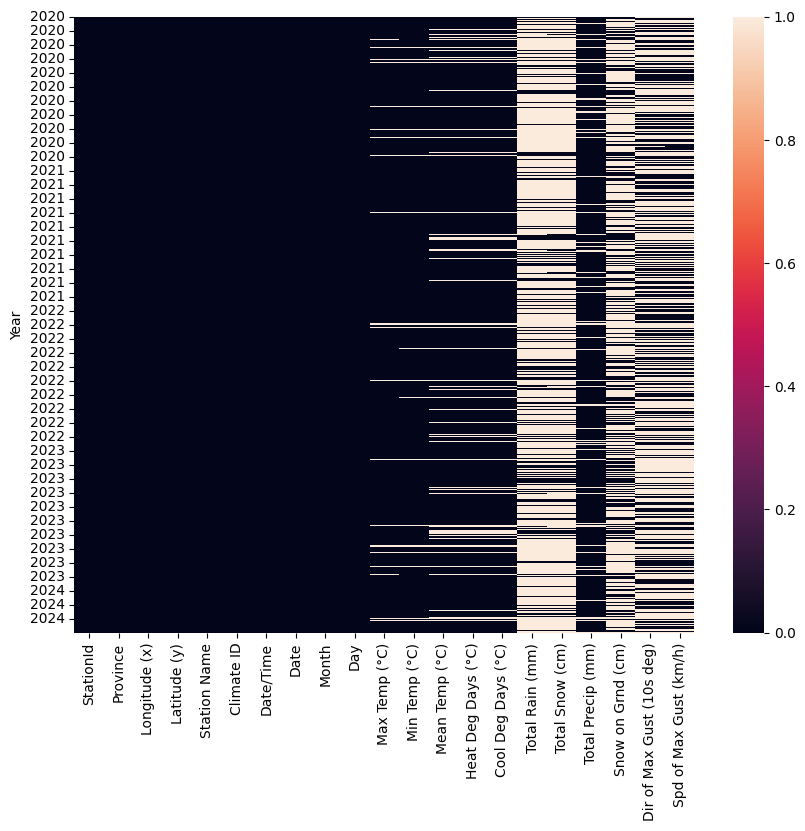

In [10]:
# Evaluation of null values
plt.figure(figsize=(10, 8))
# Reorder columns
valid_weather1 = valid_weather[['StationId', 'Province','Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
       'Date/Time', 'Date','Year', 'Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)',
       'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)',
       'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)',
        'Dir of Max Gust (10s deg)','Spd of Max Gust (km/h)']]
valid_weather1 = valid_weather1.set_index(['Year']).sort_values(by='Year')
sns.heatmap(data=valid_weather1.isnull())

# There is a lot of missing values

In [11]:
null_value = valid_weather1.isnull().sum().to_frame().sort_values(by=0, ascending=False).reset_index()
null_value = null_value.rename({'index':'Weather columns',0:'Null count'}, axis=1)
null_value['Null pourcent'] = null_value['Null count']/len(weather1)*100
null_value


,Weather columns,Null count,Null pourcent
0,Total Rain (mm),1180935,64.663768
1,Total Snow (cm),1172908,64.224238
2,Snow on Grnd (cm),971359,53.188138
3,Dir of Max Gust (10s deg),906615,49.642988
4,Spd of Max Gust (km/h),900251,49.294518
5,Mean Temp (°C),186366,10.204734
6,Cool Deg Days (°C),186366,10.204734
7,Heat Deg Days (°C),186366,10.204734
8,Total Precip (mm),168792,9.242445
9,Max Temp (°C),80519,4.408932


In [12]:
# Visualizing stations that was selected during data extraction
station_extract = pd.read_csv('dataset/CONCAT_resultdf.csv')
#station_extract = station_extract.drop(['Unnamed: 0'])
station_extract.head()

,Unnamed: 0,Province,Station ID,Status,Null pourcent,Min_Year,Max_Year,error
0,0,BRITISH COLUMBIA,26,True,2.152560,2020,2024,[]
1,1,BRITISH COLUMBIA,40,False,45.559039,2020,2024,[]
2,2,BRITISH COLUMBIA,27226,False,33.667712,2020,2024,[]
3,3,BRITISH COLUMBIA,52,True,3.824451,2020,2024,[]
4,4,BRITISH COLUMBIA,55,False,80.710554,2020,2024,[]


In [13]:
station_status = station_extract.groupby(['Province','Status'])['Status'].count().to_frame()
station_status = station_status.rename({'Status':'Status_load'}, axis=1).reset_index()
station_status = station_status.rename({'Status':'Status_load', 'Status_load':'Count'}, axis=1)
station_status = pd.pivot_table(station_status, values=['Count'], index='Province', columns=['Status_load']).reset_index()
station_status[(   'Count',  False)] = station_status[(   'Count',  False)].astype(int)
station_status[(   'Count',  True)] = station_status[(   'Count',  True)].astype(int)
station_status[(   'Count',  'Total')] = (station_status[(   'Count',  True)] + station_status[(   'Count', False)]).astype(int)
station_status[(   'Count',  'Pourcent_load')] = (station_status[(   'Count',  True)]/station_status[(   'Count',  'Total')]*100).astype(int)
station_status = station_status.sort_values(by=(   'Count',  'Pourcent_load'), ascending=False)
station_status

Province Count                         
Status_load                        False True Total Pourcent_load
9             PRINCE EDWARD ISLAND     1    8     9            88
11                    SASKATCHEWAN    11   72    83            86
0                          ALBERTA    46  227   273            83
3                    NEW BRUNSWICK     7   22    29            75
1                 BRITISH COLUMBIA    75  176   251            70
2                         MANITOBA    24   55    79            69
10                          QUEBEC    73  161   234            68
8                          ONTARIO    64  133   197            67
6                      NOVA SCOTIA    18   36    54            66
4                     NEWFOUNDLAND    21   33    54            61
12                 YUKON TERRITORY    15   15    30            50
7                          NUNAVUT    45   35    80            43
5            NORTHWEST TERRITORIES    39   27    66            40